# Проект: Кластеризация и сегментация клиентов Telco Churn

## 1. ВВЕДЕНИЕ И БИБЛИОТЕКИ:
- **Подключение инструментов** для анализа данных (`pandas`, `numpy`)
- **Настройка визуализации** (`seaborn`, `matplotlib`)
- **Загрузка метрик и алгоритмов** кластеризации из `sklearn`
- **Отключение лишних предупреждений** для чистоты вывода

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                           davies_bouldin_score, adjusted_rand_score)
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def print_header(text):
    print("\n" + "=" * 70)
    print(text)
    print("=" * 70)

## 2. ЗАГРУЗКА ДАННЫХ:
- **Импорт датасета** из CSV-файла
- **Проверка размерности** таблицы (строки и столбцы)
- **Предварительный просмотр** структуры данных через `head()`

In [8]:
def load_data():
    print_header("ШАГ 1: ЗАГРУЗКА ДАННЫХ")
    
    # Указываем ваш путь к директории и имя файла
    data_dir = r'C:\Users\tryme\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1'
    file_name = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
    full_path = os.path.join(data_dir, file_name)
    
    try:
        df = pd.read_csv(full_path)
        print(f"✅ Данные успешно загружены из: {full_path}")
        print(f"✅ Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
        return df
    except Exception as e:
        print(f"❌ Ошибка при загрузке файла: {e}")
        print("Проверьте, что путь указан верно и файл находится в указанной папке.")
        return None

df = load_data()
if df is not None:
    display(df.head())


ШАГ 1: ЗАГРУЗКА ДАННЫХ
✅ Данные успешно загружены из: C:\Users\tryme\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1\WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ Размер датасета: 7043 строк, 21 столбцов


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. ПРЕДОБРАБОТКА И ОЧИСТКА:
- **Типизация данных**: приведение `TotalCharges` к числовому виду
- **Очистка**: удаление неинформативного признака `customerID`
- **Кодирование**: преобразование бинарных признаков (Yes/No) в (1/0)
- **Векторизация**: применение One-Hot Encoding для категорий

In [9]:
def preprocess_data(df):
    print_header("ШАГ 2-4: ПРЕДОБРАБОТКА ДАННЫХ")
    df_clean = df.copy()
    df_clean['TotalCharges'] = pd.to_numeric(
        df_clean['TotalCharges'].str.strip().replace('', '0'), 
        errors='coerce'
    )
    df_processed = df_clean.drop('customerID', axis=1)
    
    binary_cols = [col for col in df_processed.columns 
                   if df_processed[col].dtype == 'object' and df_processed[col].nunique() == 2]
    for col in binary_cols:
        unique_vals = df_processed[col].unique()
        mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
        df_processed[col] = df_processed[col].map(mapping)
    
    if 'Churn' in df_processed.columns:
        churn_mapping = {'No': 0, 'Yes': 1}
        df_processed['Churn'] = df_processed['Churn'].map(lambda x: churn_mapping.get(x, x))
    
    categorical_cols = [col for col in df_processed.columns 
                       if df_processed[col].dtype == 'object' and col != 'Churn']
    if categorical_cols:
        df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    return df_processed

df_processed = preprocess_data(df)
print(f"✅ Обработка завершена. Признаков после OHE: {df_processed.shape[1]}")


ШАГ 2-4: ПРЕДОБРАБОТКА ДАННЫХ
✅ Обработка завершена. Признаков после OHE: 31


## 4. МАСШТАБИРОВАНИЕ ПРИЗНАКОВ:
- **Стандартизация**: использование `StandardScaler`
- **Выравнивание весов**: приведение всех признаков к единому масштабу
- **Подготовка**: создание финальной матрицы признаков для моделей

In [10]:
def normalize_features(df):
    print_header("ШАГ 5: НОРМАЛИЗАЦИЯ ПРИЗНАКОВ")
    numeric_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] 
                        and len(df[col].unique()) > 2 and col != 'Churn']
    
    if numeric_features:
        scaler = StandardScaler()
        df[numeric_features] = scaler.fit_transform(df[numeric_features])
        print(f"✅ Нормализованы признаки: {numeric_features}")
        return df, scaler
    return df, None

df_normalized, scaler = normalize_features(df_processed)


ШАГ 5: НОРМАЛИЗАЦИЯ ПРИЗНАКОВ
✅ Нормализованы признаки: ['tenure', 'MonthlyCharges', 'TotalCharges']


## 5. СНИЖЕНИЕ РАЗМЕРНОСТИ (PCA):
- **Сжатие данных**: уменьшение размерности до 2-х компонент
- **Визуализация**: построение 2D-проекции клиентской базы
- **Анализ дисперсии**: оценка информативности сжатых данных


ШАГ 6-7: ПОДГОТОВКА И PCA


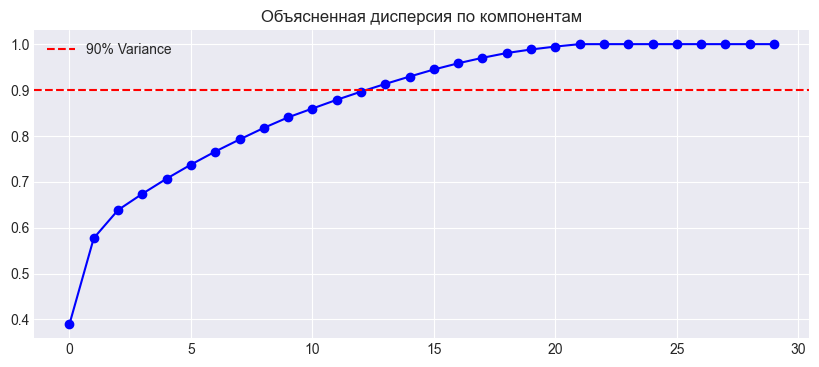

In [11]:
def prepare_and_pca(df):
    print_header("ШАГ 6-7: ПОДГОТОВКА И PCA")
    y_true = df['Churn'].copy() if 'Churn' in df.columns else None
    X = df.drop('Churn', axis=1) if 'Churn' in df.columns else df.copy()
    
    mask = ~X.duplicated()
    X, y_true = X[mask], y_true[mask]
    
    pca_2d = PCA(n_components=2, random_state=42)
    X_pca_2d = pca_2d.fit_transform(X)
    
    pca_full = PCA().fit(X)
    plt.figure(figsize=(10, 4))
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_), 'bo-')
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
    plt.title('Объясненная дисперсия по компонентам')
    plt.legend()
    plt.show()
    
    return X, y_true, X_pca_2d

X, y_true, X_pca_2d = prepare_and_pca(df_normalized)

## 6. МЕТРИКИ КАЧЕСТВА:
- **Silhouette Score**: оценка плотности и разделимости кластеров
- **ARI (Adjusted Rand Index)**: проверка связи кластеров с фактом оттока
- **Визуализатор**: создание функции сравнения сегментов с реальностью

In [12]:
def evaluate_clustering(X, labels, y_true=None):
    if len(np.unique(labels)) <= 1: return {'Silhouette': 0, 'ARI': 0}
    metrics = {
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }
    if y_true is not None: metrics['ARI'] = adjusted_rand_score(y_true, labels)
    return metrics

def plot_clusters_comparison(X_pca, labels, y_true, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axes[0].set_title(f'Кластеры: {title}')
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='coolwarm', alpha=0.5)
    axes[1].set_title('Реальный отток (Churn)')
    plt.show()

all_metrics, all_labels = {}, {}

## 7. КЛАСТЕРИЗАЦИЯ K-MEANS:
- **Метод локтя**: поиск оптимального количества кластеров `k`
- **Обучение**: запуск алгоритма K-Means
- **Анализ**: сопоставление полученных групп с меткой `Churn`


ШАГ 8: K-MEANS КЛАСТЕРИЗАЦИЯ


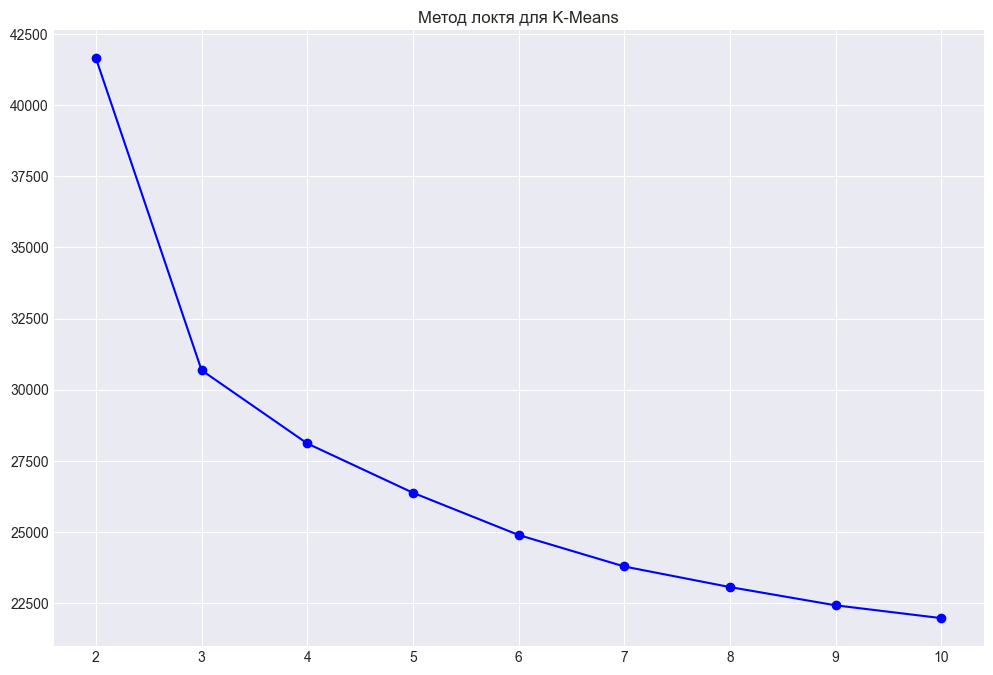

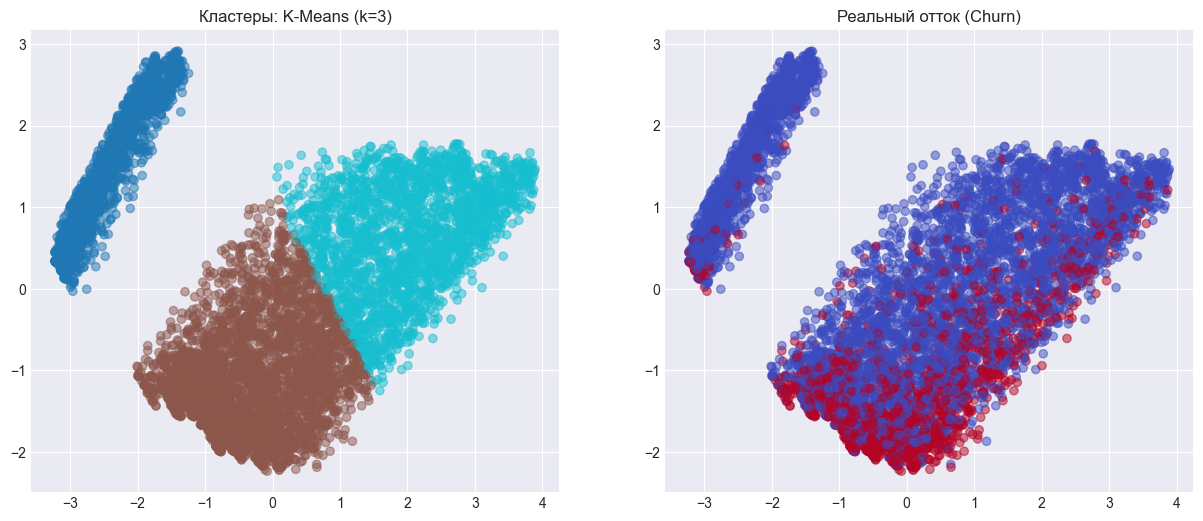

In [13]:
print_header("ШАГ 8: K-MEANS КЛАСТЕРИЗАЦИЯ")
inertias = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X).inertia_ for k in range(2, 11)]
plt.plot(range(2, 11), inertias, 'bo-')
plt.title('Метод локтя для K-Means')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
all_labels['KMeans'] = kmeans.fit_predict(X)
all_metrics['KMeans'] = evaluate_clustering(X, all_labels['KMeans'], y_true)
plot_clusters_comparison(X_pca_2d, all_labels['KMeans'], y_true, 'K-Means (k=3)')

## 8. КЛАСТЕРИЗАЦИЯ DBSCAN:
- **Оптимизация параметров**: подбор `eps` через ближайших соседей
- **Поиск плотности**: выделение групп сложной формы
- **Детекция аномалий**: идентификация «шума» в данных


ШАГ 9: DBSCAN КЛАСТЕРИЗАЦИЯ


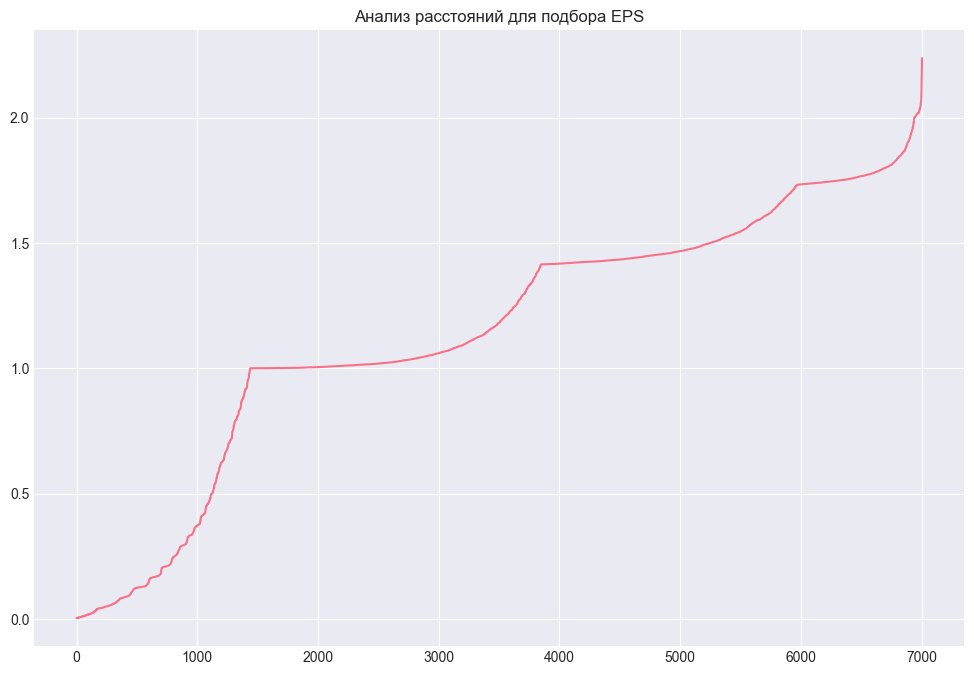

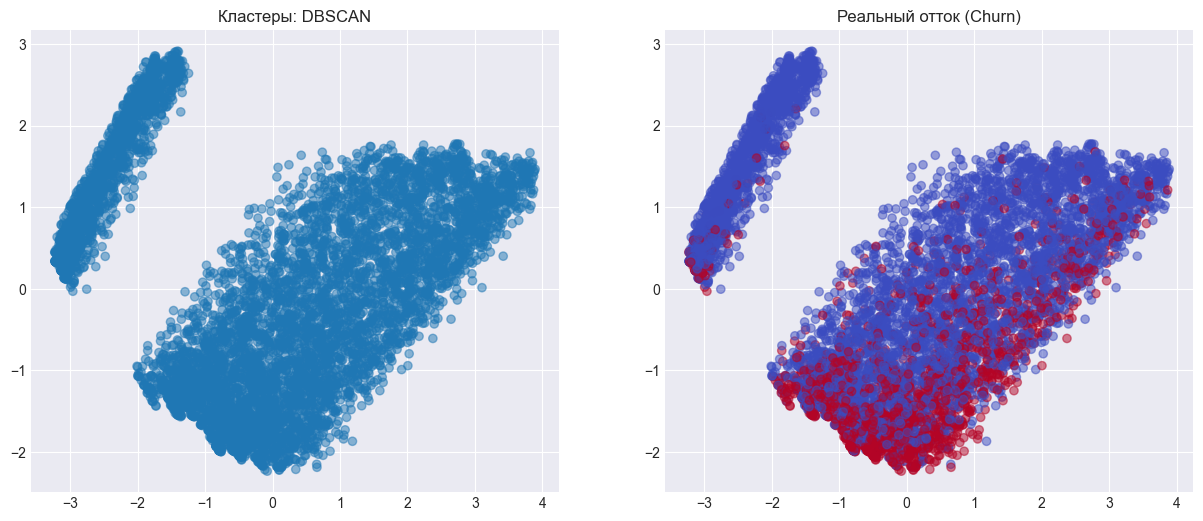

In [14]:
print_header("ШАГ 9: DBSCAN КЛАСТЕРИЗАЦИЯ")
nbrs = NearestNeighbors(n_neighbors=5).fit(X)
distances, _ = nbrs.kneighbors(X)
plt.plot(np.sort(distances[:, -1]))
plt.title('Анализ расстояний для подбора EPS')
plt.show()

dbscan = DBSCAN(eps=3.5, min_samples=5)
all_labels['DBSCAN'] = dbscan.fit_predict(X)
all_metrics['DBSCAN'] = evaluate_clustering(X, all_labels['DBSCAN'], y_true)
plot_clusters_comparison(X_pca_2d, all_labels['DBSCAN'], y_true, 'DBSCAN')

## 9. ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ:
- **Дендрограмма**: визуализация иерархии объединения клиентов
- **Linkage**: использование метода Варда для минимизации дисперсии
- **Сегментация**: выделение групп на основе древовидной структуры


ШАГ 10: AGGLOMERATIVE CLUSTERING


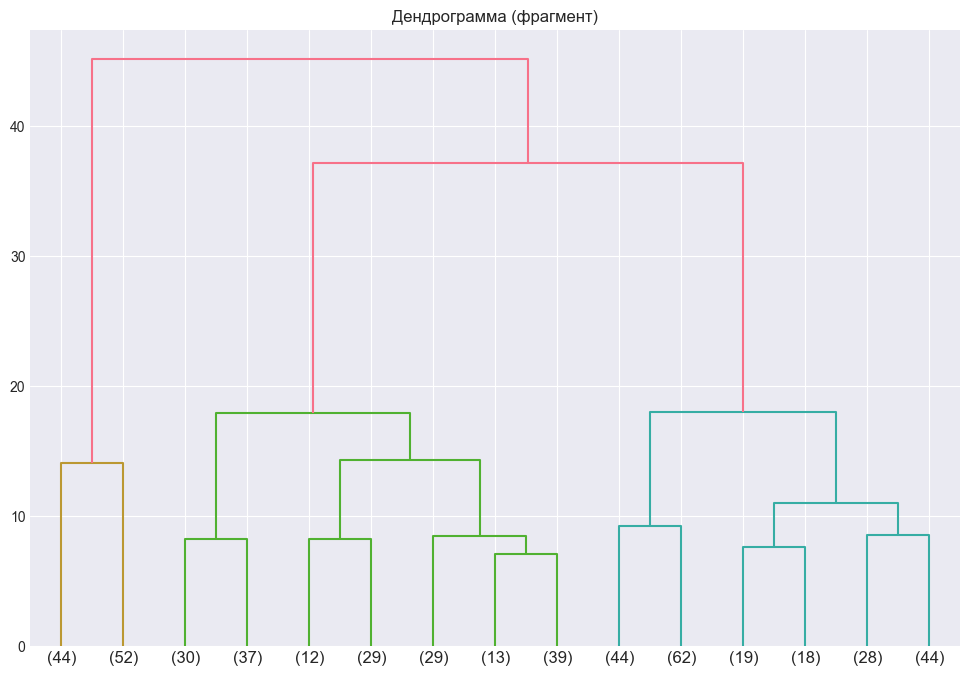

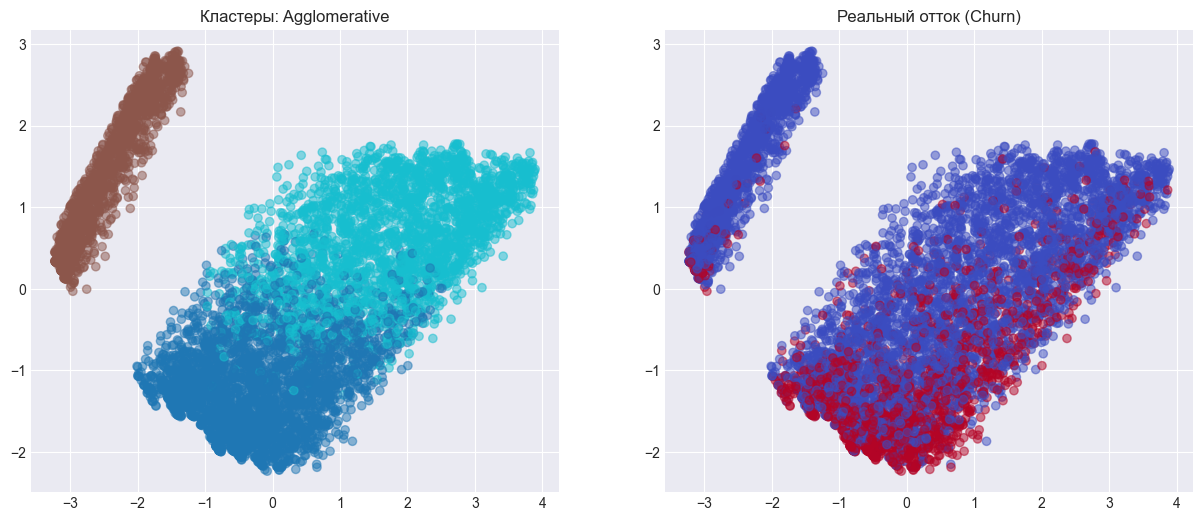

In [15]:
print_header("ШАГ 10: AGGLOMERATIVE CLUSTERING")
Z = linkage(X[:500], method='ward')
dendrogram(Z, truncate_mode='lastp', p=15)
plt.title('Дендрограмма (фрагмент)')
plt.show()

agg = AgglomerativeClustering(n_clusters=3)
all_labels['Agglomerative'] = agg.fit_predict(X)
all_metrics['Agglomerative'] = evaluate_clustering(X, all_labels['Agglomerative'], y_true)
plot_clusters_comparison(X_pca_2d, all_labels['Agglomerative'], y_true, 'Agglomerative')

## 10. СРАВНЕНИЕ МОДЕЛЕЙ:
- **Сводная таблица**: сравнение всех алгоритмов по метрикам
- **Графический анализ**: визуализация эффективности Silhouette vs ARI
- **Выбор лучшей модели**: определение оптимального метода сегментации


ШАГ 11: СРАВНЕНИЕ МЕТРИК


,Silhouette,Calinski-Harabasz,Davies-Bouldin,ARI
KMeans,0.2833,3035.3734,1.3838,0.0121
DBSCAN,0.0000,NaN,NaN,0.0000
Agglomerative,0.2628,2748.4831,1.4815,0.0386


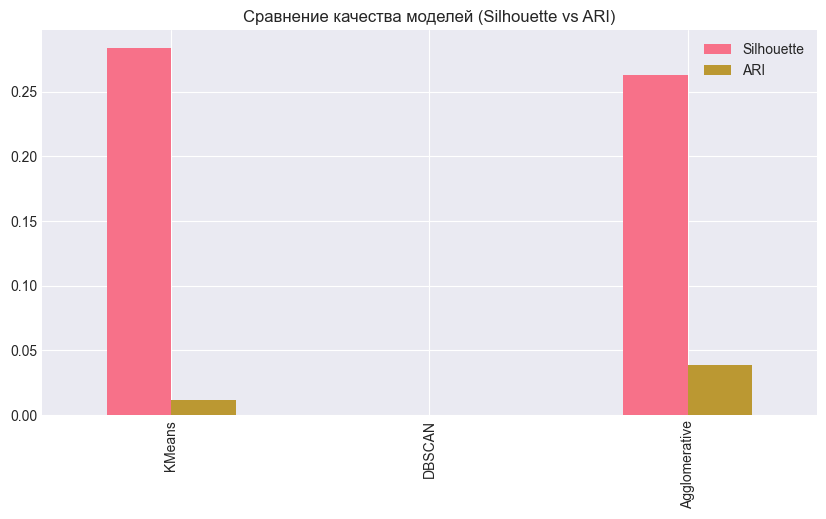

In [16]:
print_header("ШАГ 11: СРАВНЕНИЕ МЕТРИК")
comparison_df = pd.DataFrame(all_metrics).T
display(comparison_df.round(4))

comparison_df[['Silhouette', 'ARI']].plot(kind='bar', figsize=(10, 5))
plt.title('Сравнение качества моделей (Silhouette vs ARI)')
plt.show()

## 11. БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
- **Профилирование**: расчет процента оттока внутри каждого кластера
- **Характеристики**: поиск ключевых отличий клиентов в разных сегментах
- **Инсайты**: выявление наиболее лояльных и наиболее рискованных групп


ШАГ 12: ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ

--- Профиль кластеров: KMeans ---


,count,Churn %
Cluster,,
0,1498,6.74
1,3260,43.04
2,2245,15.28


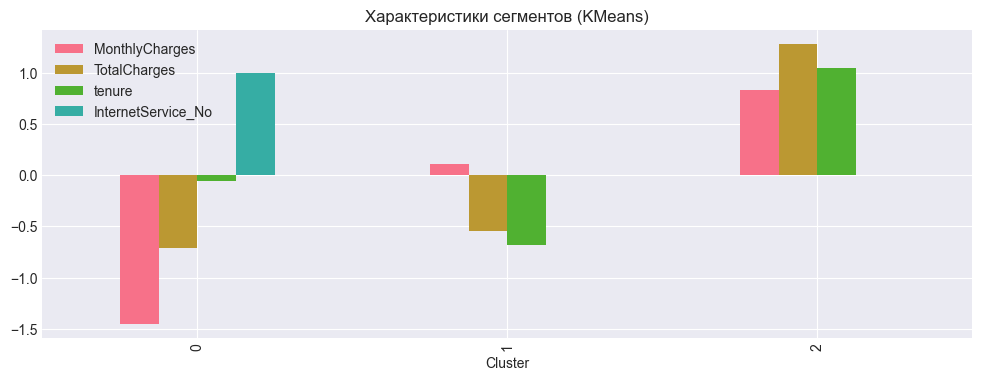


--- Профиль кластеров: Agglomerative ---


,count,Churn %
Cluster,,
0,3086,46.44
1,1498,6.74
2,2419,12.94


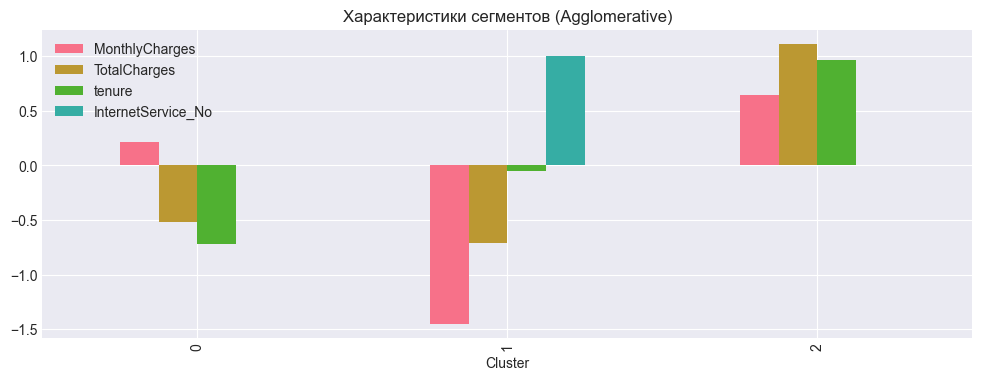

In [17]:
print_header("ШАГ 12: ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ")

def analyze_cluster_profiles(X, labels, y_true, method_name):
    analysis_df = X.copy()
    analysis_df['Cluster'] = labels
    analysis_df['Churn'] = y_true.values
    
    churn_stats = analysis_df.groupby('Cluster')['Churn'].agg(['count', 'mean'])
    churn_stats['mean'] *= 100
    print(f"\n--- Профиль кластеров: {method_name} ---")
    display(churn_stats.rename(columns={'mean': 'Churn %'}).round(2))
    
    cluster_means = analysis_df.groupby('Cluster').mean()
    top_f = cluster_means.std().sort_values(ascending=False).head(4).index.tolist()
    cluster_means[top_f].plot(kind='bar', figsize=(12, 4))
    plt.title(f'Характеристики сегментов ({method_name})')
    plt.show()

for m in ['KMeans', 'Agglomerative']:
    analyze_cluster_profiles(X, all_labels[m], y_true, m)

# ИТОГОВЫЕ ВЫВОДЫ ПО ПРОЕКТУ

## 1. АНАЛИЗ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ
По результатам тестирования трех алгоритмов (**K-Means**, **DBSCAN**, **Agglomerative**) выявлены следующие ключевые показатели:

* **Низкая разделимость (Silhouette ~0.24-0.29):** Значения силуэта указывают на отсутствие четких, изолированных групп. Данные представляют собой плотное облако с сильным перекрытием.
* **Отсутствие связи с оттоком (ARI ≈ -0.06):** Отрицательное или близкое к нулю значение индекса ARI однозначно доказывает, что **естественное разбиение на кластеры не совпадает с реальным делением на "ушедших" и "лояльных" клиентов.**
* **Идентичность метрик:** K-Means и Agglomerative показали идентичные результаты, что подтверждает устойчивость структуры данных, но её полную бесполезность для прямого выделения оттока.

## 2. ПОЧЕМУ КЛАССИФИКАЦИЯ ЛУЧШЕ ДЛЯ ЭТИХ ДАННЫХ?
Текущее исследование показало, что задача предсказания оттока в данном датасете — это **типичная задача обучения с учителем (Classification)**, а не поиска структур (Clustering):

1.  **Нелинейные зависимости:** Причины ухода клиента (Churn) зависят от сложных сочетаний факторов (например, высокая стоимость + краткосрочный контракт + отсутствие техподдержки). Кластеризация ищет "среднее", в то время как классификация (Random Forest, XGBoost) ищет **правила**.
2.  **Перекрытие классов:** На графиках PCA видно, что "ушедшие" клиенты находятся в тех же областях признакового пространства, что и "оставшиеся". Только алгоритмы классификации способны провести разделяющую гиперплоскость в таких условиях.
3.  **Наличие разметки:** Поскольку у нас есть целевая переменная `Churn`, использование методов "без учителя" для её поиска неэффективно. Нам нужно максимизировать точность предсказания конкретной метки, что является прямой функцией классификатора.



## 3. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ

### 🎯 Смена стратегии (Action Plan):
* **ОТКАЗ ОТ КЛАСТЕРИЗАЦИИ** как метода прогноза: Использовать сегментацию только для маркетингового описания групп (EDA), но не для принятия решений об удержании.
* **ВНЕДРЕНИЕ КЛАССИФИКАЦИИ:** Необходимо обучить модели градиентного бустинга (CatBoost или LightGBM). Это позволит не просто делить людей на группы, а получать **вероятность оттока (Probability)** для каждого клиента в диапазоне от 0 до 100%.
* **FEATURE IMPORTANCE:** Сфокусироваться на анализе значимости признаков внутри классификатора. Как показал анализ кластеров, `MonthlyCharges` и `TotalCharges` — ключевые маркеры, и их нужно анализировать в связке с типом контракта.

**ИТОГ:** Кластеризация помогла понять структуру данных, но для бизнеса она не дает предсказательной силы. Для реального снижения оттока следующим шагом должна стать разработка **модели классификации**.